# Feature Engineering (Ingenieria de Atributos)

Lucho Nov| 2025 <br>
Coconut by Harry Nilsson <br>

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import ta
from ta.momentum import RSIIndicator, StochasticOscillator, ROCIndicator, WilliamsRIndicator
from ta.trend import SMAIndicator, EMAIndicator, MACD, ADXIndicator, CCIIndicator
from ta.volatility import AverageTrueRange, BollingerBands

In [2]:
file_path = r"E:\data_lightstorm\data\raw\EURGBP_2020_2024.csv"

try:
    # Leer CSV
    df = pd.read_csv(file_path)

    # Eliminar duplicados
    df = df.drop_duplicates()

    # Rellenar valores nulos hacia adelante
    df = df.fillna(method="ffill")

    # Guardar copia del raw
    df_raw = df.copy()

    # Convertir columna 'date' a datetime (sin formato explícito)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Verificar fechas inválidas (NaT)
    invalid_dates = df['date'].isna().sum()
    if invalid_dates > 0:
        print(f"⚠️ {invalid_dates} filas con fecha inválida eliminadas.")
        df = df[df['date'].notna()]

    # Mostrar primeras filas
    print(df.head())

except FileNotFoundError:
    print(f"❌ Archivo no encontrado: {file_path}")
except Exception as e:
    print(f"⚠️ Error al cargar el archivo: {e}")

        date     open     high      low    close
0 2020-01-01  0.84548  0.84832  0.84505  0.84586
1 2020-01-02  0.84588  0.85142  0.84560  0.85010
2 2020-01-03  0.85000  0.85431  0.84920  0.85270
3 2020-01-06  0.85350  0.85450  0.84910  0.84966
4 2020-01-07  0.84950  0.85270  0.84650  0.84940


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1305 non-null   datetime64[ns]
 1   open    1305 non-null   float64       
 2   high    1305 non-null   float64       
 3   low     1305 non-null   float64       
 4   close   1305 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 51.1 KB


## Feature Engineering

📊 Variables Técnicas (Indicadores Financieros)

- **SMA_30**: Media móvil simple de 30 días del precio de cierre.  
- **SMA_90**: Media móvil simple de 90 días del precio de cierre.  
- **SMA_crossover**: Diferencia entre `SMA_30` y `SMA_90`.  
- **RSI**: Índice de Fuerza Relativa (14 períodos).  
- **ATR**: Rango Verdadero Promedio (14 períodos).  
- **volatility_30d**: Desviación estándar de los retornos diarios (30 días).  

---

📅 Variables Temporales

- **month**: Mes del año (1–12).  
- **quarter**: Trimestre del año (1–4).  
- **day_of_week**: Día de la semana (0–6).  
- **is_month_end**: Booleano para fin de mes.  

---

🔁 Variables Relacionales / Derivadas

- **sma_ratio**: `SMA_30 / SMA_90`.  
- **return_t**: Retorno porcentual del día *t*:  
  \[
  (close_t / close_{t-1}) - 1
  \]
- **volatility_rolling**: Volatilidad móvil (10 días).  

---

📈 Variables de Volumen (Agregadas por relevancia)

- **volume_ratio**: Volumen del día / Media móvil de volumen (30 días).  
- **volume_trend**: Tendencia de volumen (pendiente de regresión lineal 5 días).  

---

🎯 TARGET

**target**: Clasificación ternaria basada en `return_{t+1}`:

- 🟩 **up** si `return_{t+1} > 0.001`  
- 🟥 **down** si `return_{t+1} < -0.001`  
- ⬜ **neutral** en otro caso  

In [4]:
class ForexFeatureEngineer:
  
    def __init__(self):
        self.feature_columns = []
        
    def create_technical_features(self, df):
       
        print("Creando features técnicas...")
        
        # Asegurar que tenemos las columnas necesarias básicas
        required_columns = ['open', 'high', 'low', 'close']
        for col in required_columns:
            if col not in df.columns:
                raise ValueError(f"Columna requerida '{col}' no encontrada en el DataFrame")
        
        # Verificar si volume existe, si no crear uno sintético
        if 'volume' not in df.columns:
            print("⚠️  Columna 'volume' no encontrada. Creando volume sintético...")
            # Crear volume sintético basado en la volatilidad del día
            df['volume'] = ((df['high'] - df['low']) / df['close']) * 1000000
        
        # Hacer copia para no modificar el original
        df_processed = df.copy()
        
        # 1. INDICADORES DE TENDENCIA (SMA)
        print("  - Calculando SMAs...")
        df_processed['SMA_30'] = ta.trend.sma_indicator(df_processed['close'], window=30)
        df_processed['SMA_90'] = ta.trend.sma_indicator(df_processed['close'], window=90)
        df_processed['SMA_crossover'] = df_processed['SMA_30'] - df_processed['SMA_90']
        df_processed['sma_ratio'] = df_processed['SMA_30'] / df_processed['SMA_90']
        
        # 2. INDICADORES DE MOMENTUM (RSI)
        print("  - Calculando RSI...")
        df_processed['RSI'] = ta.momentum.rsi(df_processed['close'], window=14)
        
        # 3. INDICADORES DE VOLATILIDAD (ATR)
        print("  - Calculando ATR...")
        df_processed['ATR'] = ta.volatility.average_true_range(
            df_processed['high'], df_processed['low'], df_processed['close'], window=14
        )
        
        # 4. VOLATILIDAD HISTÓRICA
        print("  - Calculando volatilidades...")
        df_processed['returns'] = df_processed['close'].pct_change()
        df_processed['volatility_30d'] = df_processed['returns'].rolling(window=30).std()
        df_processed['volatility_rolling'] = df_processed['returns'].rolling(window=10).std()
        
        # 5. FEATURES DE VOLUMEN
        print("  - Calculando features de volumen...")
        df_processed['volume_ratio'] = df_processed['volume'] / df_processed['volume'].rolling(window=30).mean()
        
        # Tendencia de volumen (pendiente de regresión lineal 5 días)
        def calculate_volume_trend(volume_series):
            if len(volume_series) < 5 or volume_series.isna().any():
                return np.nan
            x = np.arange(len(volume_series))
            slope = np.polyfit(x, volume_series, 1)[0]
            return slope
        
        df_processed['volume_trend'] = df_processed['volume'].rolling(window=5).apply(
            calculate_volume_trend, raw=False
        )
        
        # 6. RETORNO DEL DÍA ACTUAL
        df_processed['return_t'] = df_processed['close'].pct_change()
        
        # Limpiar columnas temporales
        df_processed = df_processed.drop(['returns'], axis=1)
        
        return df_processed
    
    def create_temporal_features(self, df, date_column='date'):
        """
        Crear features temporales a partir de la columna de fecha con Pandas
        """
        print("Creando features temporales...")
        
        # Asegurar que la columna de fecha existe
        if date_column not in df.columns:
            raise ValueError(f"Columna de fecha '{date_column}' no encontrada")
        
        # Hacer copia para no modificar el original
        df_processed = df.copy()
        
        # Convertir a datetime si no lo es
        if not pd.api.types.is_datetime64_any_dtype(df_processed[date_column]):
            df_processed[date_column] = pd.to_datetime(df_processed[date_column])
        
        # Extraer componentes temporales
        df_processed['month'] = df_processed[date_column].dt.month
        df_processed['quarter'] = df_processed[date_column].dt.quarter
        df_processed['day_of_week'] = df_processed[date_column].dt.dayofweek  # 0=Lunes, 6=Domingo
        df_processed['is_month_end'] = df_processed[date_column].dt.is_month_end.astype(int)
        
        # Features cíclicas para mes y día de la semana
        df_processed['month_sin'] = np.sin(2 * np.pi * df_processed['month'] / 12)
        df_processed['month_cos'] = np.cos(2 * np.pi * df_processed['month'] / 12)
        df_processed['day_sin'] = np.sin(2 * np.pi * df_processed['day_of_week'] / 7)
        df_processed['day_cos'] = np.cos(2 * np.pi * df_processed['day_of_week'] / 7)
        
        return df_processed
    
    def create_target(self, df):
        """
        Crear target de clasificación ternaria con Pandas
        """
        print("Creando variable target...")
        
        # Hacer copia para no modificar el original
        df_processed = df.copy()
        
        # Calcular retorno del día siguiente
        df_processed['return_t1'] = df_processed['close'].shift(-1) / df_processed['close'] - 1
        
        # Definir condiciones para clasificación ternaria
        conditions = [
            df_processed['return_t1'] > 0.001,    # UP: sube más del 0.1%
            df_processed['return_t1'] < -0.001    # DOWN: baja más del 0.1%
        ]
        choices = ['up', 'down']
        
        # Aplicar condiciones
        df_processed['target'] = np.select(conditions, choices, default='neutral')
        
        # Mapear a valores numéricos para el modelo
        target_map = {'down': 0, 'neutral': 1, 'up': 2}
        df_processed['target_encoded'] = df_processed['target'].map(target_map)
        
        return df_processed
    
    def get_feature_columns(self):
        """
        Retorna la lista de columnas de features
        """
        technical_features = [
            'SMA_30', 'SMA_90', 'SMA_crossover', 'RSI', 'ATR', 
            'volatility_30d', 'volatility_rolling', 'sma_ratio', 'return_t',
            'volume_ratio', 'volume_trend'
        ]
        
        temporal_features = [
            'month', 'quarter', 'day_of_week', 'is_month_end',
            'month_sin', 'month_cos', 'day_sin', 'day_cos'
        ]
        
        return technical_features + temporal_features
    
    def prepare_features(self, df, date_column='date'):
        """
        Pipeline completo de feature engineering con Pandas
        """
        print("="*60)
        print("INICIANDO PIPELINE DE FEATURE ENGINEERING")
        print("="*60)
        
        # Hacer copia para no modificar el original
        df_processed = df.copy()
        
        print(f"Dataset de entrada: {df_processed.shape[0]} filas, {df_processed.shape[1]} columnas")
        print(f"Columnas disponibles: {list(df_processed.columns)}")
        
        # Aplicar transformaciones
        df_processed = self.create_technical_features(df_processed)
        df_processed = self.create_temporal_features(df_processed, date_column)
        df_processed = self.create_target(df_processed)
        
        # Obtener lista de columnas de features
        self.feature_columns = self.get_feature_columns()
        
        # Limpiar valores infinitos y NaN
        df_processed = df_processed.replace([np.inf, -np.inf], np.nan)
        
        # Eliminar filas con NaN en features o target
        initial_shape = df_processed.shape[0]
        df_processed = df_processed.dropna(subset=self.feature_columns + ['target_encoded'])
        final_shape = df_processed.shape[0]
        
        print(f"\n📊 RESULTADOS DEL FEATURE ENGINEERING:")
        print(f"   - Filas eliminadas por NaN: {initial_shape - final_shape}")
        print(f"   - Filas finales: {final_shape}")
        print(f"   - Total features creadas: {len(self.feature_columns)}")
        
        # Distribución del target
        target_dist = df_processed['target'].value_counts()
        print("\n🎯 DISTRIBUCIÓN DEL TARGET:")
        for label, count in target_dist.items():
            percentage = (count / len(df_processed)) * 100
            print(f"   - {label}: {count} ({percentage:.1f}%)")
        
        return df_processed

In [5]:
engineer = ForexFeatureEngineer()
df_features = engineer.prepare_features(df, date_column='date')

INICIANDO PIPELINE DE FEATURE ENGINEERING
Dataset de entrada: 1305 filas, 5 columnas
Columnas disponibles: ['date', 'open', 'high', 'low', 'close']
Creando features técnicas...
⚠️  Columna 'volume' no encontrada. Creando volume sintético...
  - Calculando SMAs...
  - Calculando RSI...
  - Calculando ATR...
  - Calculando volatilidades...
  - Calculando features de volumen...
Creando features temporales...
Creando variable target...

📊 RESULTADOS DEL FEATURE ENGINEERING:
   - Filas eliminadas por NaN: 89
   - Filas finales: 1216
   - Total features creadas: 19

🎯 DISTRIBUCIÓN DEL TARGET:
   - down: 480 (39.5%)
   - up: 413 (34.0%)
   - neutral: 323 (26.6%)


In [6]:
output_path = r"E:\data_lightstorm\data\processed\EURGBP_features.csv"
df_features.to_csv(output_path, index=False)
print(f"\n💾 Dataset procesado guardado en: {output_path}")


💾 Dataset procesado guardado en: E:\data_lightstorm\data\processed\EURGBP_features.csv


In [7]:
df_features.head()

,date,open,high,low,close,volume,SMA_30,SMA_90,SMA_crossover,sma_ratio,...,quarter,day_of_week,is_month_end,month_sin,month_cos,day_sin,day_cos,return_t1,target,target_encoded
89,2020-05-05,0.87628,0.87640,0.86898,0.87110,8517.965790,0.879439,0.866178,0.013261,1.015310,...,2,1,0,0.5,-0.866025,0.781831,0.623490,0.005131,up,2
90,2020-05-06,0.87534,0.87606,0.87370,0.87557,2695.387005,0.877942,0.866508,0.011434,1.013195,...,2,2,0,0.5,-0.866025,0.974928,-0.222521,0.000263,neutral,1
91,2020-05-07,0.87556,0.87897,0.87070,0.87580,9442.795159,0.876885,0.866794,0.010091,1.011642,...,2,3,0,0.5,-0.866025,0.433884,-0.900969,-0.002706,down,0
92,2020-05-08,0.87584,0.87654,0.87120,0.87343,6113.827095,0.876181,0.867024,0.009157,1.010562,...,2,4,0,0.5,-0.866025,-0.433884,-0.900969,0.003206,up,2
93,2020-05-11,0.87331,0.88067,0.87200,0.87623,9894.662360,0.875686,0.867319,0.008367,1.009647,...,2,0,0,0.5,-0.866025,0.000000,1.000000,0.009415,up,2


In [8]:
df_features.describe().T

,count,mean,min,25%,50%,75%,max,std
date,1216,2022-09-02 02:24:28.421052672,2020-05-05 00:00:00,2021-07-04 06:00:00,2022-09-01 12:00:00,2023-11-01 06:00:00,2024-12-31 00:00:00,NaN
open,1216.0,0.863277,0.82299,0.84922,0.858805,0.87584,0.92471,0.021286
high,1216.0,0.865996,0.82514,0.851815,0.861195,0.878947,0.92916,0.021809
low,1216.0,0.860867,0.8201,0.847275,0.856725,0.872725,0.9208,0.020849
close,1216.0,0.863284,0.823,0.84919,0.85872,0.875857,0.92552,0.021292
volume,1216.0,5917.253629,671.554088,3838.280277,5224.806854,7256.866047,47598.398933,3148.634045
SMA_30,1216.0,0.863842,0.829196,0.84921,0.858908,0.87605,0.912066,0.020178
SMA_90,1216.0,0.864852,0.834324,0.851261,0.860953,0.875897,0.905604,0.018651
SMA_crossover,1216.0,-0.001009,-0.022663,-0.005066,-0.002006,0.003437,0.016664,0.007068
sma_ratio,1216.0,0.998826,0.974302,0.994046,0.997683,1.003861,1.019392,0.008119



🎯 Distribución del Target:
target
down       39.5
up         34.0
neutral    26.6
Name: proportion, dtype: float64


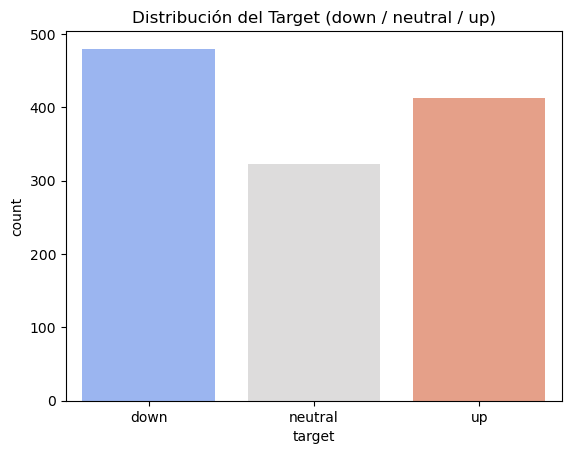

In [9]:
print("\n🎯 Distribución del Target:")
dist = df_features['target'].value_counts(normalize=True).round(3) * 100
print(dist)

sns.countplot(data=df_features, x='target', order=['down', 'neutral', 'up'], palette='coolwarm')
plt.title("Distribución del Target (down / neutral / up)")
plt.show()

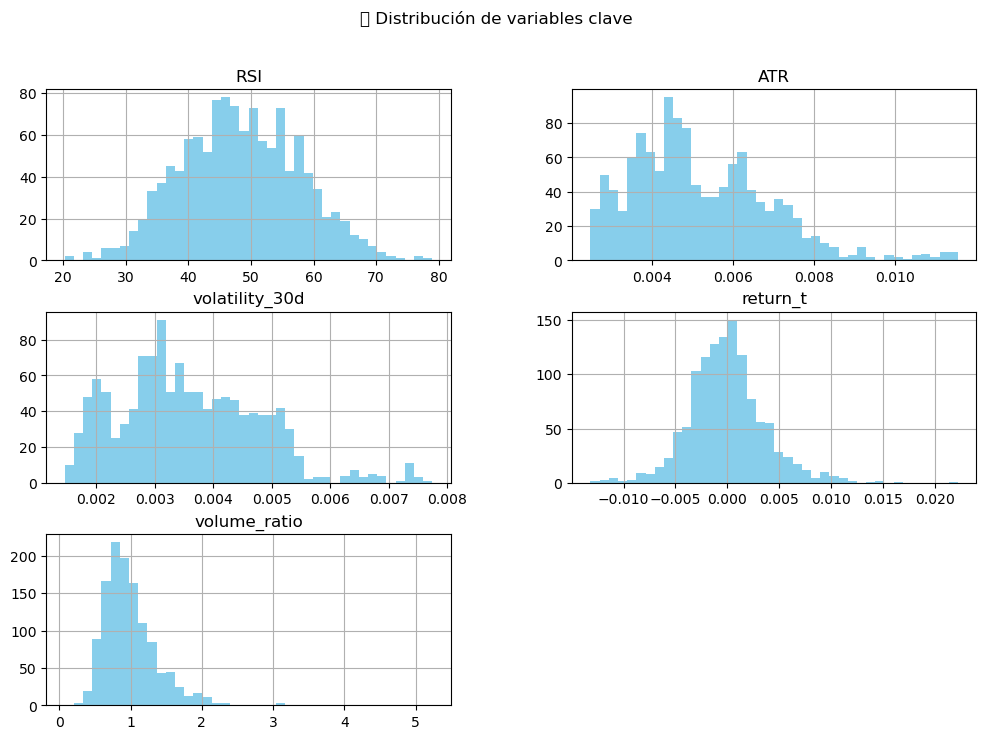

In [10]:
key_features = ['RSI', 'ATR', 'volatility_30d', 'return_t', 'volume_ratio']
df_features[key_features].hist(bins=40, figsize=(12, 8), color='skyblue')
plt.suptitle("📈 Distribución de variables clave")
plt.show()

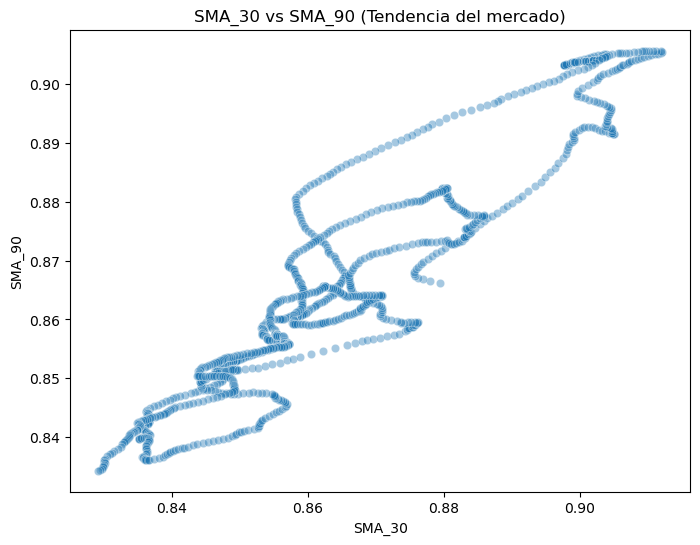

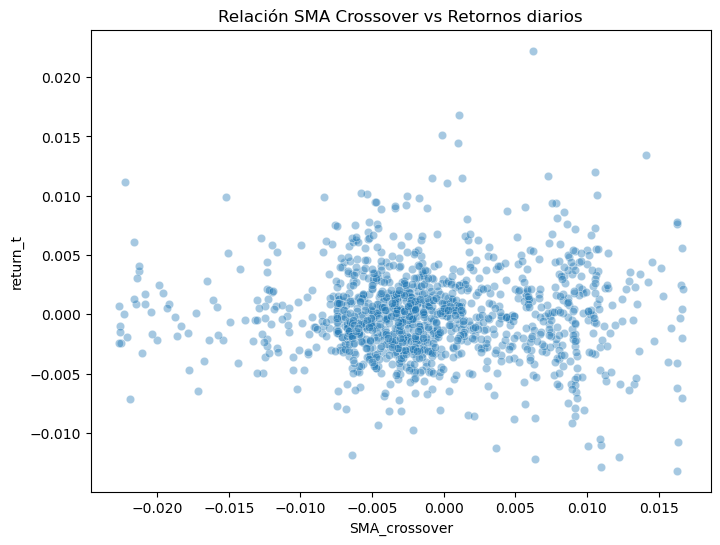

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_features, x='SMA_30', y='SMA_90', alpha=0.4)
plt.title("SMA_30 vs SMA_90 (Tendencia del mercado)")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_features, x='SMA_crossover', y='return_t', alpha=0.4)
plt.title("Relación SMA Crossover vs Retornos diarios")
plt.show()

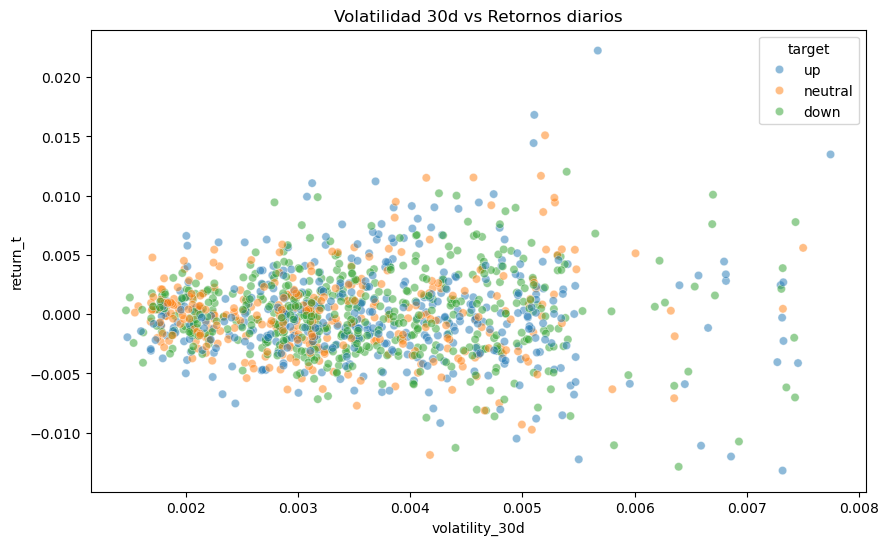

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_features, x='volatility_30d', y='return_t', hue='target', alpha=0.5)
plt.title("Volatilidad 30d vs Retornos diarios")
plt.show()


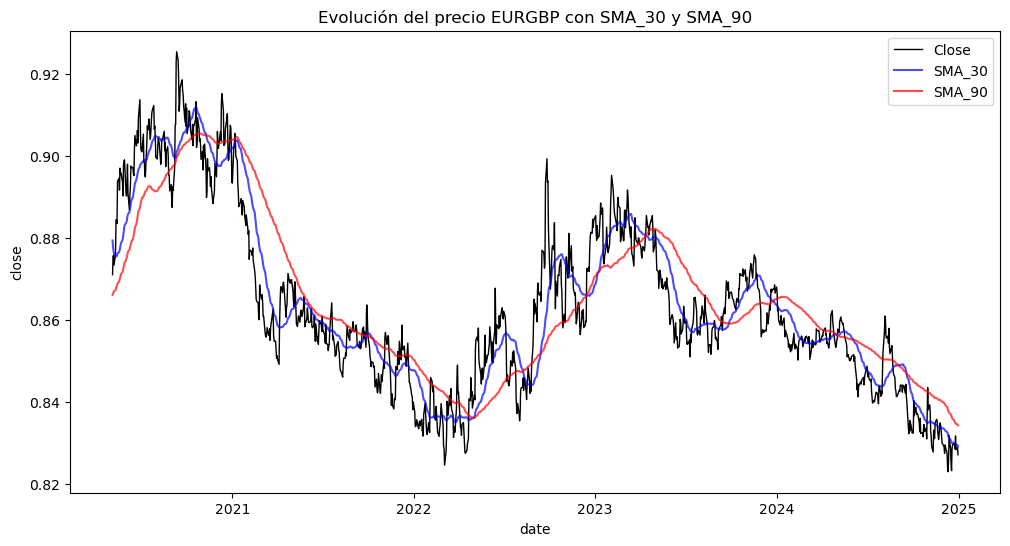

In [13]:
if 'date' in df_features.columns:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_features, x='date', y='close', label='Close', color='black', linewidth=1)
    sns.lineplot(data=df_features, x='date', y='SMA_30', label='SMA_30', color='blue', alpha=0.7)
    sns.lineplot(data=df_features, x='date', y='SMA_90', label='SMA_90', color='red', alpha=0.7)
    plt.title("Evolución del precio EURGBP con SMA_30 y SMA_90")
    plt.legend()
    plt.show()

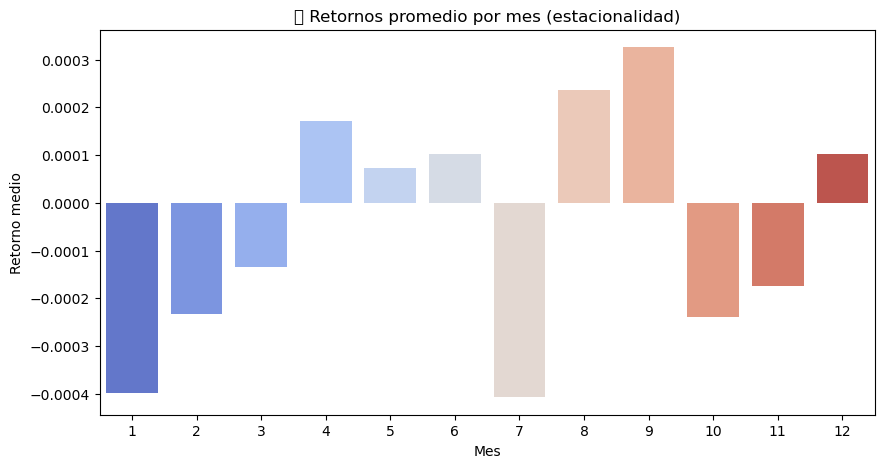

In [14]:
if 'month' in df_features.columns:
    monthly_perf = df_features.groupby('month')['return_t'].mean()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=monthly_perf.index, y=monthly_perf.values, palette='coolwarm')
    plt.title("📅 Retornos promedio por mes (estacionalidad)")
    plt.xlabel("Mes")
    plt.ylabel("Retorno medio")
    plt.show()


📊 Analizando relación entre volatilidad y tendencia...


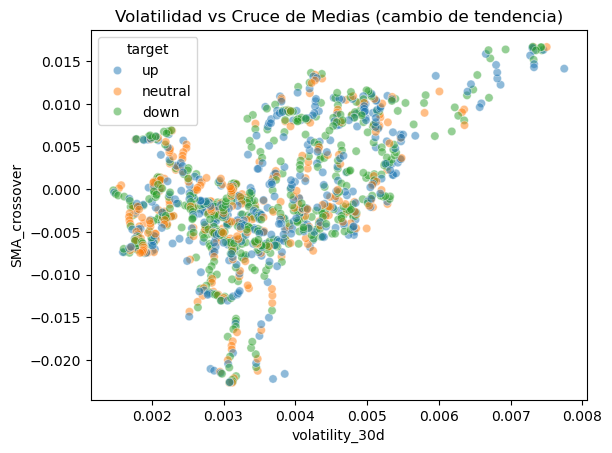

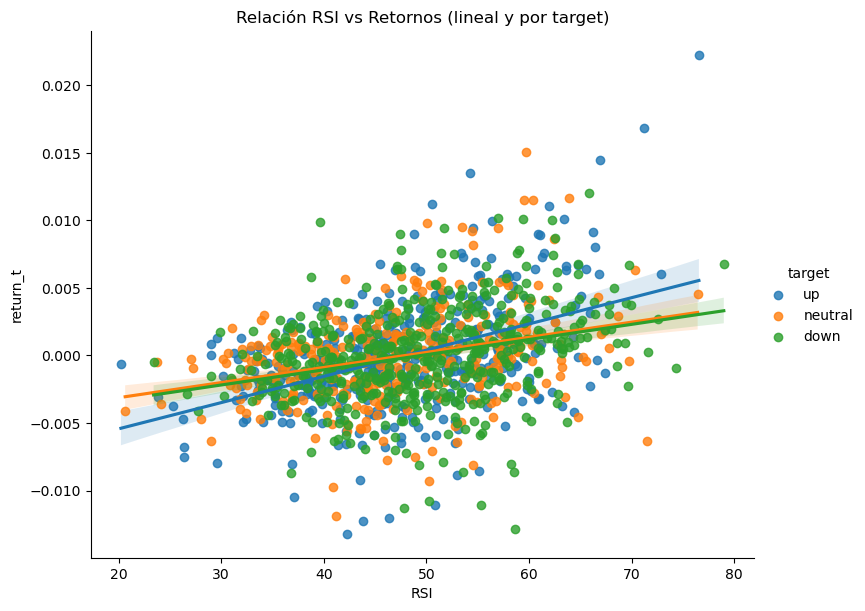

In [15]:
print("\n📊 Analizando relación entre volatilidad y tendencia...")

sns.scatterplot(data=df_features, x='volatility_30d', y='SMA_crossover', hue='target', alpha=0.5)
plt.title("Volatilidad vs Cruce de Medias (cambio de tendencia)")
plt.show()

sns.lmplot(data=df_features, x='RSI', y='return_t', hue='target', aspect=1.3, height=6)
plt.title("Relación RSI vs Retornos (lineal y por target)")
plt.show()

Análisis Integral de los Gráficos

1. Relación RSI vs Retornos (lineal y por target)

**Objetivo:**  
Evaluar si el Índice de Fuerza Relativa (RSI) tiene poder predictivo sobre los retornos futuros (`return_t`), segmentado por la etiqueta `target` (`up`, `neutral`, `down`).

Observaciones

- Existe una relación positiva débil pero significativa entre el RSI y los retornos futuros, como lo indican las líneas de regresión ajustadas para cada grupo.  
- La pendiente de la línea de regresión para `target = up` (azul) es la más pronunciada, seguida por `neutral` (naranja) y luego `down` (verde).  
  Esto sugiere que cuando el mercado está en tendencia alcista (*up*), un aumento en el RSI se asocia con mayores retornos futuros.  
- El RSI alto (por encima de 70) tiende a estar asociado con retornos positivos, especialmente en el grupo *up*.  
  Esto podría parecer contraintuitivo (ya que un RSI > 70 suele indicar sobrecompra), pero indica que en este dataset, los niveles altos de RSI no necesariamente preceden a correcciones, sino que pueden ser parte de una tendencia fuerte.  
- La dispersión de los puntos es considerable, lo que implica que el RSI no es un predictor perfecto, pero puede ser útil como señal complementaria.

Insight Científico

El RSI muestra una **correlación positiva con los retornos futuros**, especialmente en mercados alcistas.  
Su utilidad como *feature* en un modelo predictivo sería moderada, y debería combinarse con otras variables para mejorar la precisión.  
No se observa una relación inversa clara en sobrecompra, lo que podría indicar que el mercado estudiado tiene una dinámica de *tendencia fuerte* donde los extremos no siempre se revertían rápidamente.  

---

2. Volatilidad vs Cruce de Medias (cambio de tendencia)

**Objetivo:**  
Analizar la relación entre la volatilidad (30 días) y el cruce de medias móviles (`SMA_crossover`), segmentado por `target`.

Observaciones

- No hay una relación lineal clara entre la volatilidad y el cruce de medias. Los puntos están dispersos sin una tendencia definida.  
- Sin embargo, se observa una aglomeración de puntos en regiones específicas:  
  - Cuando la volatilidad es baja (< 0.004), el `SMA_crossover` tiende a ser negativo o cercano a cero.  
  - Con volatilidad alta (> 0.006), el cruce tiende a ser positivo.  
- El grupo `target = up` (azul) domina en la región de alta volatilidad y cruce positivo, lo que sugiere que los cambios de tendencia alcista ocurren frecuentemente en periodos de alta volatilidad.  
- El grupo `down` (verde) tiende a concentrarse en volatilidades intermedias y cruces negativos.

Insight Científico

El **cruce de medias móviles** parece ser más efectivo como señal de cambio de tendencia en entornos de **alta volatilidad**.  
Esto apoya la idea de que los movimientos de tendencia suelen acelerarse cuando la volatilidad aumenta.  
Un modelo que combine `volatility_30d` y `SMA_crossover` podría tener mejor rendimiento si se aplica un umbral de volatilidad mínimo para activar la señal.  

---

3. Retornos promedio por mes (estacionalidad)

**Objetivo:**  
Identificar patrones estacionales en los retornos mensuales.

Observaciones

- Se observa una clara estacionalidad:  
  Los meses de **enero (1)**, **febrero (2)**, **marzo (3)** y **julio (7)** muestran retornos negativos consistentes.  
- Los meses de **abril (4)**, **mayo (5)**, **junio (6)**, **agosto (8)**, **septiembre (9)**, **octubre (10)**, **noviembre (11)** y **diciembre (12)** presentan retornos positivos, siendo **septiembre (9)** el mes con el retorno promedio más alto.  
- La diferencia entre los peores y mejores meses es significativa:  
  - Retorno promedio en septiembre ≈ **+0.0003**  
  - Retorno promedio en enero ≈ **-0.0004**

Insight Científico

Existe una **fuerte estacionalidad mensual** en los retornos.  
Este patrón podría ser utilizado para diseñar **estrategias de trading basadas en calendario** (*calendar strategies*).  
Por ejemplo:
- Evitar posiciones largas en **enero** y **julio**.  
- Aumentar exposición en **agosto** y **septiembre**.  

Es crucial validar esta estacionalidad en múltiples años para asegurar que no sea un artefacto del periodo muestreado.  

---

4. Evolución del precio EURGBP con SMA_30 y SMA_90

**Objetivo:**  
Visualizar la evolución del precio y la interacción de las medias móviles en el tiempo.

Observaciones

- Las medias móviles actúan como soportes y resistencias dinámicas. El precio tiende a rebotar en las medias, especialmente en la `SMA_90`.  
- Los cruces entre `SMA_30` y `SMA_90` coinciden con cambios de tendencia:  
  - Cuando `SMA_30` cruza hacia arriba `SMA_90`, el precio tiende a subir (ejemplo: principios de 2021, mediados de 2023).  
  - Cuando cruza hacia abajo, el precio tiende a caer (ejemplo: finales de 2021, mediados de 2024).  
- La `SMA_90` sigue la tendencia general a largo plazo, mientras que la `SMA_30` captura movimientos de corto plazo.

Insight Científico

Las **medias móviles** son herramientas útiles para identificar tendencias y puntos de inflexión.  
Un sistema de trading basado en el cruce de estas medias podría generar señales rentables, aunque con un **retardo inherente** debido a su naturaleza de promedio móvil.  
La validación con métricas como el **ratio de Sharpe** y la **máxima drawdown** es necesaria antes de implementarlo.  

---

5. SMA_30 vs SMA_90 (Tendencia del mercado)

**Objetivo:**  
Visualizar la relación entre las dos medias móviles en un espacio bidimensional para entender la dinámica de la tendencia.

Observaciones

- La nube de puntos forma una estructura diagonal ascendente, lo que indica que ambas medias móviles tienden a moverse en la misma dirección, pero con diferentes velocidades.  
- Los puntos se agrupan en zonas donde `SMA_30 > SMA_90` (cuadrante superior derecho) y `SMA_30 < SMA_90` (cuadrante inferior izquierdo), lo que refleja claramente las fases alcistas y bajistas.  
- La densidad de puntos en la diagonal sugiere que los cambios de tendencia ocurren gradualmente, no de forma abrupta.

Insight Científico

Este gráfico confirma que el **cruce de medias móviles es una señal robusta de cambio de tendencia**.  
La distribución de los puntos en la diagonal también indica que las medias móviles están altamente correlacionadas, lo cual es esperable.  
Para mejorar la señal, se podría considerar el uso de la **pendiente de las medias** o su **divergencia relativa**, en lugar solo del cruce.  

---

Conclusiones Generales y Recomendaciones

Resumen de Insights Clave

- **RSI:** Tiene una correlación positiva con los retornos, especialmente en mercados alcistas. Útil como *feature*, pero no suficiente por sí solo.  
- **Volatilidad y Cruce de Medias:** Los cambios de tendencia son más probables en períodos de alta volatilidad. Combinar ambos *features* puede mejorar la calidad de las señales.  
- **Estacionalidad:** Hay un patrón claro de retornos mensuales, con meses favorables (agosto-septiembre) y desfavorables (enero-julio). Estrategias basadas en calendario podrían ser rentables.  
- **Medias Móviles:** Son efectivas para identificar tendencias y puntos de inflexión. El cruce de `SMA_30` y `SMA_90` es una señal válida, aunque con retardo.  
- **Dinámica de Tendencia:** La relación entre `SMA_30` y `SMA_90` es consistente y predecible, lo que permite modelar la tendencia del mercado de forma visual y cuantitativa.
